In [ ]:
###############################################################
# Scalling Analysis for the Flat Scan Sampling multi core
# João Inácio, Apr. 16th, 2021
# 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, linregress

In [ ]:
# System and simulation information

dim = "2D"
lattice = "SS"
NN = 4

L = 8
N_atm = 1 * L ** 2

max_E = (1 / 2) * NN * N_atm
max_M = N_atm
NE = int(1 + (max_E / 2))
NM = N_atm + 1
energies = np.linspace(- max_E, max_E, NE)
magnetizations = np.linspace(- max_M, max_M, NM)

REP = 10 ** 4
skip = N_atm

q_max = (NM + 1) // 2 - 2
if NM % 2 == 0:
    q_max = NM // 2 - 3

n_cores = 2 ** np.array([1, 2, 3])


In [ ]:
# Initialization of data arrays

n_run = 100

JDOS_all = list()
for i in range(len(n_cores)):
    JDOS_all.append(list())

wall_time_all = np.zeros((n_run, len(n_cores)))
q_time_E_all = np.zeros((n_run, len(n_cores)))

cfg_chkbrd = np.zeros((n_run, len(n_cores)))
cfg_slice = np.zeros((n_run, len(n_cores)))
cfg_zerozero = np.zeros((n_run, len(n_cores)))

JDOS_mean = list()
wall_time_mean = list()
q_time_E_mean = list()


In [ ]:
# Get the single core data

for run in range(1, n_run + 1):
    file_name = "".join(("./data/", lattice, "/L", str(L), "/", 
                         str(int(np.log10(REP))), "/", str(run), "_JDOS_FSS_Ising_", 
                         dim, "_", lattice, "_L", str(L), "_REP_1E",
                         str(int(np.log10(REP))), "_skip_", str(skip)))
    JDOS = np.loadtxt(file_name + ".txt")
    JDOS[:, q_max+2:NM] = JDOS[:, range(q_max, -1, -1)]
    
    cfg_chkbrd[run - 1, 0] = JDOS[len(energies) - 1, q_max+1]
    cfg_slice[run - 1, 0] = JDOS[L, q_max+1]
    cfg_zerozero[run - 1, 0] = JDOS[np.where(energies == 0)[0][0], q_max+1]

    JDOS_all[0].append(JDOS)
    
    with open(file_name + "_data.txt", 'r') as data_file:
        header = data_file.readline().strip("\n")
        
        q_time_E = np.zeros(q_max)
        for i in range(0, q_max):
            line = data_file.readline().strip("\n").split(" ")
            q_time_E[i] = float(line[4])

        wall_time_all[run - 1, 0] = float(data_file.readline().strip("\n"))
        q_time_E_all[run - 1, 0] = np.sum(q_time_E)

JDOS_mean.append(np.average(JDOS_all[0]))
wall_time_mean.append(np.average(wall_time_all[:, 0]))
q_time_E_mean.append(np.average(q_time_E_all[:, 0]))

print(np.log2(n_cores[0]))
print("Mean Wall time: {:.5f} seconds".format(wall_time_mean[0]))
print("Mean q_time / E: {:.5f} seconds".format(q_time_E_mean[0]))
print("------------------------------------")


In [ ]:
# Get the multi core data

k = 0
for n in np.log2(n_cores[:]):
    for run in range(1, n_run + 1):
        file_name = "".join(("./data_mc/data/", lattice, "/L", str(L), "/", 
                             str(int(n)), "/", str(run), "_JDOS_FSS_Ising_", 
                             dim, "_", lattice, "_L", str(L), "_REP_1E",
                             str(int(np.log10(REP))), "_skip_", str(skip)))
        JDOS = np.loadtxt(file_name + ".txt")
        JDOS[:, q_max+2:NM] = JDOS[:, range(q_max, -1, -1)]

        cfg_chkbrd[run - 1, k] = JDOS[len(energies) - 1, q_max+1]
        cfg_slice[run - 1, k] = JDOS[L, q_max+1]
        cfg_zerozero[run - 1, k] = JDOS[np.where(energies == 0)[0][0], q_max+1]

        JDOS_all[k].append(JDOS)

        with open(file_name + "_data.txt", 'r') as data_file:
            header = data_file.readline().strip("\n")

            q_time_E = np.zeros(q_max)
            for i in range(0, q_max):
                line = data_file.readline().strip("\n").split(" ")
                q_time_E[i] = float(line[4])

            wall_time_all[run - 1, k] = float(data_file.readline().strip("\n"))
            q_time_E_all[run - 1, k] = np.sum(q_time_E)
    
    JDOS_mean.append(np.average(JDOS_all[k]))
    wall_time_mean.append(np.average(wall_time_all[:, k]))
    q_time_E_mean.append(np.average(q_time_E_all[:, k]))
    
    print(n)
    print("Mean Wall time: {:.5f} seconds".format(wall_time_mean[k]))
    print("Mean q_time / E: {:.5f} seconds".format(q_time_E_mean[k]))
    print("------------------------------------")
    
    k += 1


In [ ]:
# Get the shuffle multi core data

JDOS_all_shuffle = list()
for i in range(len(n_cores) - 1):
    JDOS_all_shuffle.append(list())

wall_time_all_shuffle = np.zeros((n_run, len(n_cores) - 1))
q_time_E_all_shuffle = np.zeros((n_run, len(n_cores) - 1))

cfg_chkbrd_shuffle = np.zeros((n_run, len(n_cores) - 1))
cfg_slice_shuffle = np.zeros((n_run, len(n_cores) - 1))
cfg_zerozero_shuffle = np.zeros((n_run, len(n_cores) - 1))

JDOS_mean_shuffle = list()
wall_time_mean_shuffle = list()
q_time_E_mean_shuffle = list()

k = 0
for n in np.log2(n_cores[1:]):
    for run in range(1, n_run + 1):
        file_name = "".join(("./data_mc/shuffle/", lattice, "/L", str(L), "/", 
                             str(int(n)), "/", str(run), "_shuffle_JDOS_FSS_Ising_", 
                             dim, "_", lattice, "_L", str(L), "_REP_1E",
                             str(int(np.log10(REP))), "_skip_", str(skip)))
        JDOS = np.loadtxt(file_name + ".txt")
        JDOS[:, q_max+2:NM] = JDOS[:, range(q_max, -1, -1)]

        cfg_chkbrd_shuffle[run - 1, k] = JDOS[len(energies) - 1, q_max+1]
        cfg_slice_shuffle[run - 1, k] = JDOS[L, q_max+1]
        cfg_zerozero_shuffle[run - 1, k] = JDOS[np.where(energies == 0)[0][0], q_max+1]

        JDOS_all_shuffle[k].append(JDOS)

        with open(file_name + "_data.txt", 'r') as data_file:
            header = data_file.readline().strip("\n")

            q_time_E = np.zeros(q_max)
            for i in range(0, q_max):
                line = data_file.readline().strip("\n").split(" ")
                q_time_E[i] = float(line[4])

            wall_time_all_shuffle[run - 1, k] = float(data_file.readline().strip("\n"))
            q_time_E_all_shuffle[run - 1, k] = np.sum(q_time_E)
    
    JDOS_mean_shuffle.append(np.average(JDOS_all_shuffle[k]))
    wall_time_mean_shuffle.append(np.average(wall_time_all_shuffle[:, k]))
    q_time_E_mean_shuffle.append(np.average(q_time_E_all_shuffle[:, k]))
    
    print(n)
    print("Mean Wall time: {:.5f} seconds".format(wall_time_mean_shuffle[k]))
    print("Mean q_time / E: {:.5f} seconds".format(q_time_E_mean_shuffle[k]))
    print("------------------------------------")
    
    k += 1


In [6]:
# Data from slurm files

n_cores = np.array([1, 7, 15, 31, 63])
wall_time_mean = np.array([15823, 2387.91, 1154.97, 594.082, 320.836])


NameError: name 'q_time_E_mean' is not defined

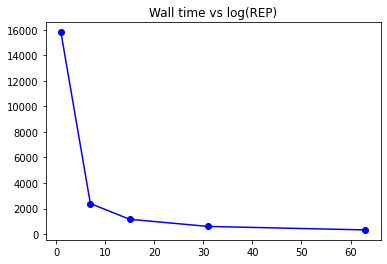

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot Wall time and q_time/E

# Wall time
plt.figure(1)
plt.plot(n_cores, wall_time_mean, '-ob')
#plt.plot(n_cores[1:], wall_time_mean_shuffle, '-or')
plt.title("Wall time vs log(REP)")
    
# q_time/E
plt.figure(2)
plt.plot(n_cores, q_time_E_mean, '-ob')
#plt.plot(n_cores[1:], q_time_E_mean_shuffle, '-or')

plt.title("q_time/E vs log(REP)")

plt.show()


0.77385888864943 1.347426317498197 0.9972151156784889


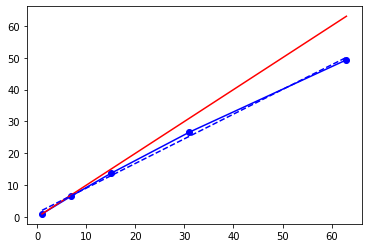

In [15]:
# Speedup

speedup = np.zeros(len(n_cores))

for k in range(len(n_cores)):
    speedup[k] = wall_time_mean[0] / wall_time_mean[k]
    
result = linregress(n_cores[:], speedup)
print(result.slope, result.intercept, result.rvalue**2)
    
plt.plot(n_cores[:], speedup, '-ob')
plt.plot(n_cores[:], n_cores[:], '-r')
plt.plot(n_cores[:], result.slope * n_cores[:] + result.intercept, '--b')

plt.show()
